# Appendix B: Combining queries

In this example, we'll walk through the process of building a more complex query for the MSMARCO Document dataset. This assumes that you are familiar with the other query tuning notebooks. We'll be using the `cross_fields` and `best_fields` queries and the optimal parameters found as the foundation on which we build a more complex query.

As with the previous notebook and in accordance with the MSMARCO Document ranking task, we'll continue to use MRR@100 on the `dev` dataset for evaluation and comparison with other approaches.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [27]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, optimize_query_mrr100
from qopt.optimize import Config

In [10]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://35.234.93.126:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
# max_concurrent_searches = 10
max_concurrent_searches = 30

index = 'msmarco-document'
template_id = 'combined'

## Combining `cross_fields` and `best_fields`

Based on previous tuning, we have the following optimal parameters for each `multi_match` query type.

In [5]:
cross_fields_params = {
    'operator': 'OR',
    'minimum_should_match': 40,
    'tie_breaker': 0.25,
    'url|boost': 1.8047232930155708,
    'title|boost': 10.0,
    'body|boost': 6.569708296455422,
}

best_fields_params = {
    'tie_breaker': 0.4295450971050169,
    'url|boost': 0.0,
    'title|boost': 5.631895782981447,
    'body|boost': 7.10619804961409,
}

We've seen the process to optimize field boosts on two different `multi_match` queries but it would be interesting to see if combining them in some way might actually result in even better MRR@100. Let's give it a shot and find out.

Side note: Combining queries where each sub-query is always executed may improve relevance but it will hurt performance and the query times will be quite a lot higher than with a single, simpler query. Keep this in mind when building complex queries for production!

In [8]:
def prefix_keys(d, prefix):
    return {f'{prefix}{k}': v for k, v in d.items()}

# prefix key of each sub-query
# add default boosts
all_params = {
    **prefix_keys(cross_fields_params, 'cross_fields|'),
    'cross_fields|boost': 1.0,
    **prefix_keys(best_fields_params, 'best_fields|'),
    'best_fields|boost': 1.0,
}
all_params

{'cross_fields|operator': 'OR',
 'cross_fields|minimum_should_match': 40,
 'cross_fields|tie_breaker': 0.25,
 'cross_fields|url|boost': 1.8047232930155708,
 'cross_fields|title|boost': 10.0,
 'cross_fields|body|boost': 6.569708296455422,
 'cross_fields|boost': 1.0,
 'best_fields|tie_breaker': 0.4295450971050169,
 'best_fields|url|boost': 0.0,
 'best_fields|title|boost': 5.631895782981447,
 'best_fields|body|boost': 7.10619804961409,
 'best_fields|boost': 1.0}

## Baseline evaluation

In [11]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params=all_params)

Score: 0.3062
CPU times: user 1.91 s, sys: 483 ms, total: 2.39 s
Wall time: 4min 36s


## Query tuning

Here we'll just tune the boosts for each sub-query. Note that this takes twice as long as tuning individual queries because we have two queries combined.

In [12]:
%%time

_, _, final_params_boosts, metadata_boosts = optimize_query_mrr100(es, max_concurrent_searches, index, template_id,
    config_space=Config.parse({
        'num_iterations': 30,
        'num_initial_points': 5,
        'space': {
            'cross_fields|boost': { 'low': 0.0, 'high': 5.0 },
            'best_fields|boost': { 'low': 0.0, 'high': 5.0 },
        },
        'default': all_params,
    }))

Optimizing parameters
 - iteration 1 scored 0.2793 with: {'cross_fields|boost': 0.6129197135919707, 'best_fields|boost': 2.610168190452915}
 - iteration 2 scored 0.2788 with: {'cross_fields|boost': 4.776364695490323, 'best_fields|boost': 3.6856575625612606}
 - iteration 3 scored 0.2757 with: {'cross_fields|boost': 4.5870026984537695, 'best_fields|boost': 2.0865928146937893}
 - iteration 4 scored 0.2773 with: {'cross_fields|boost': 1.6498123847111787, 'best_fields|boost': 1.0466523274975912}
 - iteration 5 scored 0.2793 with: {'cross_fields|boost': 0.5719038710493053, 'best_fields|boost': 2.2271080272550945}
 - iteration 6 scored 0.2787 with: {'cross_fields|boost': 0.9195107349201493, 'best_fields|boost': 0.8325091408041309}
 - iteration 7 scored 0.2783 with: {'cross_fields|boost': 0.026289916893073587, 'best_fields|boost': 3.4594928561542746}
 - iteration 8 scored 0.2695 with: {'cross_fields|boost': 0.1729689449456834, 'best_fields|boost': 0.014511829980683457}
 - iteration 9 scored 0.

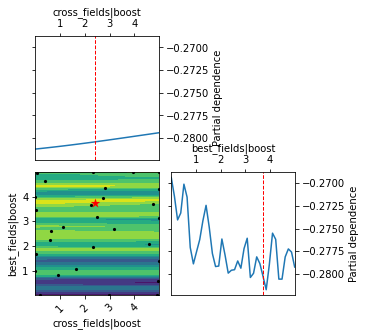

In [13]:
_ = plot_objective(metadata_boosts, sample_source='result')

This is, errr, complicated. Seems that there's not much to tune here and it's a difficult parameter space with lots of peaks and valleys.

In [20]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id, params=final_params_boosts)

Score: 0.3064
CPU times: user 1.79 s, sys: 453 ms, total: 2.25 s
Wall time: 4min 47s


Well that's actually slightly worse than the `best_fields` alone. Something is not working.

## Debugging

Plot scores from each sub-query to determine why we don't really see an improvement over individual queries.

In [28]:
import matplotlib.pyplot as plt
from itertools import chain

from qopt.notebooks import ROOT_DIR
from qopt.search import temporary_search_template, search_template
from qopt.trec import load_queries_as_tuple_list, load_qrels

In [29]:
def collect_scores():
    
    def _search(template_id, query_string, params, doc_id):
        res = search_template(es, index, template_id, query={
            'id': 0,
            'params': {
                'query_string': query_string,
                **params,
            },
        })
        return [hit['score'] for hit in res['hits'] if hit['id'] == doc_id]

    queries = load_queries_as_tuple_list(os.path.join(ROOT_DIR, 'data', 'msmarco-document-sampled-queries.1000.tsv'))
    qrels = load_qrels(os.path.join(ROOT_DIR, 'data', 'msmarco', 'document', 'msmarco-doctrain-qrels.tsv'))
    template_file = os.path.join(ROOT_DIR, 'config', 'msmarco-document-templates.json')
    size = 100
    
    cross_field_scores = []
    best_field_scores = []
    
    with temporary_search_template(es, template_file, 'cross_fields', size) as cross_fields_template_id:
        with temporary_search_template(es, template_file, 'best_fields', size) as best_fields_template_id:
            for query in queries:
                doc_id = list(qrels[query[0]].keys())[0]
                
                cfs = _search(cross_fields_template_id, query[1], cross_fields_params, doc_id)
                bfs = _search(best_fields_template_id, query[1], best_fields_params, doc_id)

                # keep just n scores to make sure the lists are the same length
                length = min(len(cfs), len(bfs))
                cross_field_scores.append(cfs[:length])
                best_field_scores.append(bfs[:length])

    return cross_field_scores, best_field_scores

In [30]:
cfs, bfs = collect_scores()

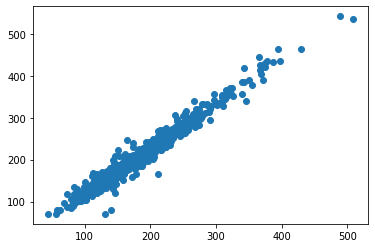

In [31]:
# plot scores
cfs_flat = list(chain(*cfs))
bfs_flat = list(chain(*bfs))

plt.scatter(cfs_flat, bfs_flat)
plt.show()

It looks like combining queries really won't do much. Seems that the scores from each sub-query are already pretty aligned and we can't benefit from learning the boost values which tell us how to combine scores.